In [449]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from typing import Dict, List, Set
import numpy as np
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [450]:
locations_synonyms: Dict[str, List[str]] = {
    "Warszawa": ["Warsaw", "Warszawa", "Katowice; Warszawa", "Warszawa (Centrum)", "Waraszawa"],
    "Kraków": ["Krakow", "Kraków"],
    "Wrocław": ["Wroclaw", "Wrocław"],
    "Poznań": ["Poznan", "Poznań", "Pozanań"],
    "Gdańsk": ["Gdansk", "Gdańsk"],
    "Szczecin": ["Szczecin", "szczecin"],
    "Łódź": ["Lodz", "Łódź"],
    "Rzeszów": ["Rzeszow", "Rzeszów"],
    "Katowice": ["Katowice", "Katowice; Warszawa"],
    "Kielce": ["Kielce"],
    "Opole": ["opole", "Opole"],
    "Sopot": ["Sopot"],
    "Olszytn": ["Olsztyn"],
    "Gdynia": ["Gdynia"],
}

location_encoder = LabelEncoder()
exp_encoder = LabelEncoder()
mode_encoder = LabelEncoder()

# read data from json file
df = pd.read_json("../data/offers.json")

def replace_synonyms(locations):
    for standard, synonyms in locations_synonyms.items():
        for i, loc in enumerate(locations):
            if loc in synonyms:
                locations[i] = standard
    return locations

def split_contracts(row):
    contracts = []
    if row['min_b2b'] > 0 or row['max_b2b'] > 0:
        new_row_b2b = row.copy()
        new_row_b2b['min_uop'] = 0
        new_row_b2b['max_uop'] = 0
        new_row_b2b['avg_salary'] = (new_row_b2b['min_b2b'] + new_row_b2b['max_b2b']) / 2
        new_row_b2b['contract_type'] = 'B2B'
        contracts.append(new_row_b2b)
    if row['min_uop'] > 0 or row['max_uop'] > 0:
        new_row_uop = row.copy()
        new_row_uop['min_b2b'] = 0
        new_row_uop['max_b2b'] = 0
        new_row_uop['avg_salary'] = (new_row_uop['min_uop'] + new_row_uop['max_uop']) / 2
        new_row_uop['contract_type'] = 'UoP'
        contracts.append(new_row_uop)
    return contracts

split_rows = df.apply(lambda row: pd.DataFrame(split_contracts(row)), axis=1)
df = pd.concat(split_rows.values.tolist(), ignore_index=True)

contract_type_encoder = LabelEncoder()
df["contract_type_code"] = contract_type_encoder.fit_transform(df["contract_type"])
df = df.drop(columns=["contract_type", "min_b2b", "max_b2b", "min_uop", "max_uop"])

df["locations"] = df["locations"].apply(replace_synonyms)
df = df.explode("locations")
df["location"] = df["locations"]

df["location_code"] = location_encoder.fit_transform(df["location"])

df["experience_code"] = exp_encoder.fit_transform(df["experience"])
df["operating_mode_code"] = mode_encoder.fit_transform(df["operating_mode"])
df = df.drop(columns=["locations", "operating_mode", "experience", "location"])

mlb = MultiLabelBinarizer()

df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('technologies')),
                          columns=mlb.classes_,
                          index=df.index))

df.to_csv("../data/offers_normalized_locations.csv", index=False)    


## Usuwanie niepotrzebnych danych

Na wszelki wypadek usuwam niepotrzebne dane, które mogą być niepotrzebne w przyszłości.
<p style="color: red">W przypadku ofert pracy gdzie nie ma definiowanych widełek dla np. b2b nie będę ich próbował wyliczać, bo nie ma to sensu, ponieważ zarobki zależą od technologi i poziomu doświadczenia.</p> 


In [451]:
offers = pd.read_csv("../data/offers_normalized_locations.csv")

offers = offers.drop_duplicates()
offers = offers.dropna()

rows_to_drop = offers[offers['avg_salary'] < 1000].index
offers = offers.drop(rows_to_drop)
offers = offers.drop(columns=["title"])

offers.columns = offers.columns.str.strip()

offers.to_csv("../data/jobs.csv", index=False)

## Zapis i naprawa danych z formatu JSON do CSV.

Na początku tworze sobie synonimy dla najpopularniejszych nazw miast, ponieważ w niektórych przypadkach, 
miasta mają w sobie literówki np. `Waraszawa` albo nie obsłużyłem wystarczająco dużo przypadków przy miastach.
Następnie naprawiamy sobie lokacje oraz technologie. W przypadku technologii nie naprawam ich ponieważ mam pewność że są poprawne przez to ze były w jednym miejscu na stronie oraz po przejrzeniu ich nie znalazłem błędów.

# Szybki look na dane

In [452]:
data = pd.read_csv('../data/jobs.csv')
df = pd.DataFrame(data)
# title,min_b2b,max_b2b,min_uop,max_uop,experience,operating_mode,experience_code,operating_mode_code
display(df.tail())

,avg_salary,contract_type_code,location_code,experience_code,operating_mode_code,AWS,Angular,Azure,C#,C++,...,React,Ruby,SQL,Scala,Spring,Terraform,TypeScript,Vue.js,Windows,android
5746,34250.0,1,37,2,2,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
5747,34250.0,1,4,2,2,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
5748,34250.0,1,59,2,2,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
5749,29000.0,0,7,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5750,23500.0,1,7,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [453]:
print(len(df))

5751


# Zarobki na kontrakcie B2B 

In [454]:
exp_code = df["experience_code"].value_counts().index
exp_name = exp_encoder.inverse_transform(exp_code)
contracts = df["contract_type_code"].value_counts().index
contracts_name = contract_type_encoder.inverse_transform(contracts)

for exp in exp_name:
    exp_code = exp_encoder.transform([exp])[0]
    for contract in contracts_name:
        contract_code = contract_type_encoder.transform([contract])[0]
        subset = df[(df["experience_code"] == exp_code) & (df["contract_type_code"] == contract_code)]
        print(f"Experience: {exp}, Contract Type: {contract}")
        display(subset.iloc[:, :2].describe().round(2))

Experience: Senior, Contract Type: B2B


,avg_salary,contract_type_code
count,2285.00,2285.0
mean,25700.81,0.0
std,5721.74,0.0
min,9791.00,0.0
25%,22000.00,0.0
50%,25000.00,0.0
75%,28800.00,0.0
max,52500.00,0.0


Experience: Senior, Contract Type: UoP


,avg_salary,contract_type_code
count,1135.00,1135.0
mean,22318.03,1.0
std,6871.30,0.0
min,10000.00,1.0
25%,17200.00,1.0
50%,21000.00,1.0
75%,26000.00,1.0
max,60000.00,1.0


Experience: Mid, Contract Type: B2B


,avg_salary,contract_type_code
count,1491.00,1491.0
mean,18025.50,0.0
std,4396.18,0.0
min,3132.50,0.0
25%,15000.00,0.0
50%,18000.00,0.0
75%,21000.00,0.0
max,32500.00,0.0


Experience: Mid, Contract Type: UoP


,avg_salary,contract_type_code
count,681.00,681.0
mean,15210.38,1.0
std,3432.43,0.0
min,6000.00,1.0
25%,12850.00,1.0
50%,15500.00,1.0
75%,17250.00,1.0
max,27500.00,1.0


Experience: Junior, Contract Type: B2B


,avg_salary,contract_type_code
count,101.00,101.0
mean,9902.18,0.0
std,2546.98,0.0
min,5200.00,0.0
25%,8276.50,0.0
50%,9500.00,0.0
75%,11000.00,0.0
max,16100.00,0.0


Experience: Junior, Contract Type: UoP


,avg_salary,contract_type_code
count,58.00,58.0
mean,11057.05,1.0
std,4767.74,0.0
min,5500.00,1.0
25%,7000.00,1.0
50%,10250.00,1.0
75%,14300.00,1.0
max,19000.00,1.0


# Tworzymy histogramy

Proponuje następujące rozkłady:
- typu pracy
- doświadczenia
- zarobków
- technologii
- lokalizacji


Zacznijmy od napisania funkcji która będzie tworzyć histogramy dla każdej z tych kategorii.

In [455]:
import pandas as pd
import matplotlib.pyplot as plt

def get_histogram(data, column_name, title, encoder, label_x="", label_y="", is_specified=False, exp=None):
    if is_specified:
        exp_code = exp_encoder.transform([exp])[0]
        print(f"Experience: {exp}")
        data = data[data["experience_code"] == exp_code]
    # Zliczanie unikalnych wartości w kolumnie
    value_counts = data[column_name].value_counts().head(12)
    
    # Dekodowanie kodów na nazwy
    location_names = encoder.inverse_transform(value_counts.index)
    value_counts.index = location_names
    print(value_counts)
    
    # Tworzenie wykresu kołowego
    plt.figure(figsize=(8, 8))
    value_counts.plot(kind='pie', autopct='%1.1f%%')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"plots/rozkłady/{title.lower().replace(" ", "_")}.png")
    plt.show()



In [456]:
def compute_amount_offers_for(exp):
    exp_code = exp_encoder.transform([exp])[0]
    offers_amount = df['experience_code'].value_counts()[exp_code]
    print(f"Liczba ofert pracy dla {exp}a:", offers_amount)
    return offers_amount
    
mid_offers = compute_amount_offers_for("Mid")
senior_offers  = compute_amount_offers_for("Senior")
junior_offers =  compute_amount_offers_for("Junior")

assert mid_offers + senior_offers + junior_offers == len(df)

Liczba ofert pracy dla Mida: 2172
Liczba ofert pracy dla Seniora: 3420
Liczba ofert pracy dla Juniora: 159


## Histogram typu pracy

Remote    4761
Hybrid     803
Office     187
Name: count, dtype: int64


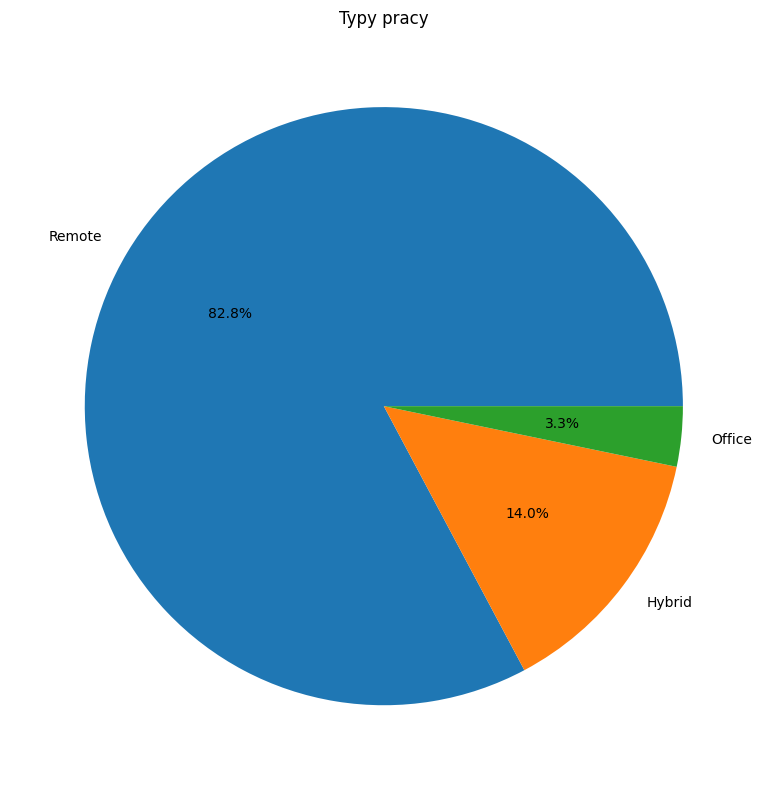

In [457]:
get_histogram(df, 'operating_mode_code', 'Typy pracy', encoder=mode_encoder)

## Histogram doświadczenia

Senior    3420
Mid       2172
Junior     159
Name: count, dtype: int64


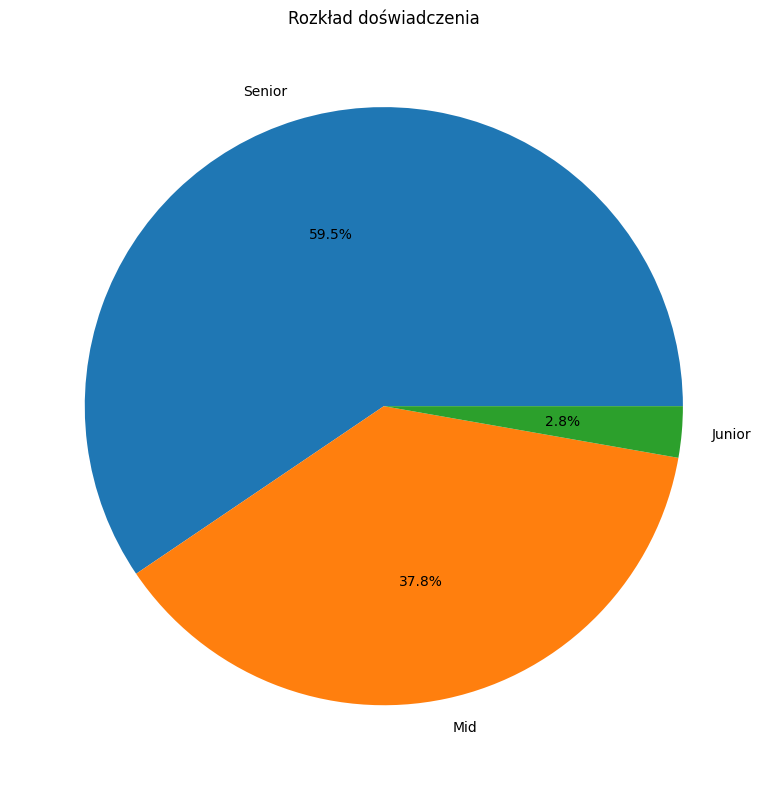

In [458]:
get_histogram(df, 'experience_code', title="Rozkład doświadczenia", label_x="", label_y="", encoder=exp_encoder)

# Rozkład zarobków na B2B

In [459]:
def salary_distribution(data, exp, encoder=exp_encoder, color='skyblue'):
    exp_code = encoder.transform([exp])[0]
    b2b, uop = contract_type_encoder.transform(["B2B", "UoP"])
    df_filtered_b2b = data[(data["experience_code"] == exp_code) & (data["contract_type_code"] == b2b)].copy()

    print(f"Rozkład wynagrodzeń dla {exp}, liczba ofert z b2b: {len(df_filtered_b2b)}")

    plt.figure(figsize=(10, 6))

    sns.kdeplot(df_filtered_b2b['avg_salary'], color=color, label='B2B')

    df_filtered_uop = data[(data["experience_code"] == exp_code) & (data["contract_type_code"] == uop)].copy()
    
    print(f"Rozkład wynagrodzeń dla {exp}, liczba ofert z uop: {len(df_filtered_uop)}")

    sns.kdeplot(df_filtered_uop['avg_salary'], color='red', label='UOP')

    plt.title(f"Rozkład zarobków {exp}a")
    plt.xlabel(f"Średnie wynagrodzenie {exp}a")
    plt.ylabel("Gęstość ofert")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/rozkłady/pensje_dla_{exp.lower()}a.png")
    plt.show()

Rozkład wynagrodzeń dla Mid, liczba ofert z b2b: 1491
Rozkład wynagrodzeń dla Mid, liczba ofert z uop: 681


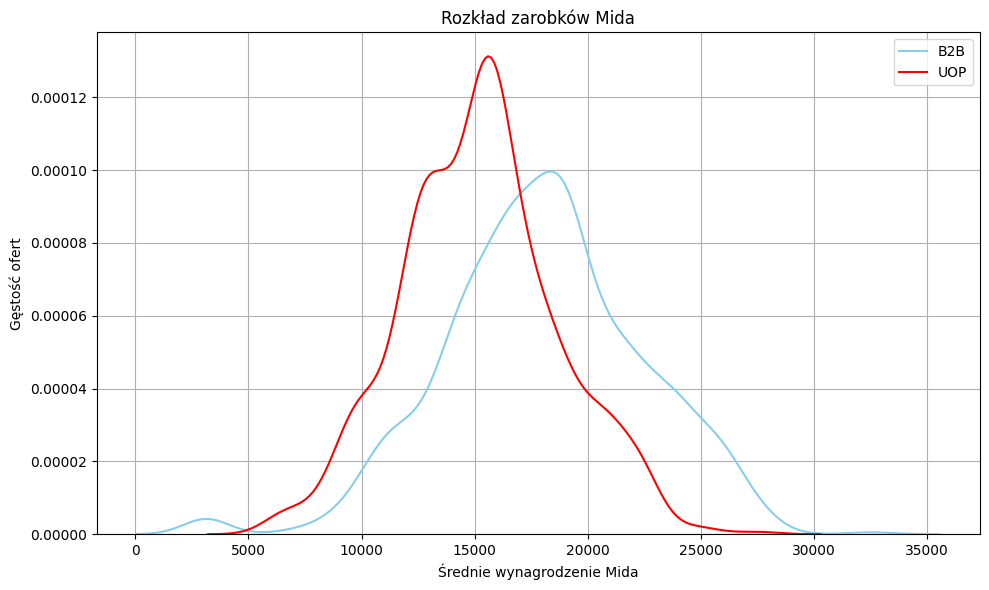

Rozkład wynagrodzeń dla Senior, liczba ofert z b2b: 2285
Rozkład wynagrodzeń dla Senior, liczba ofert z uop: 1135


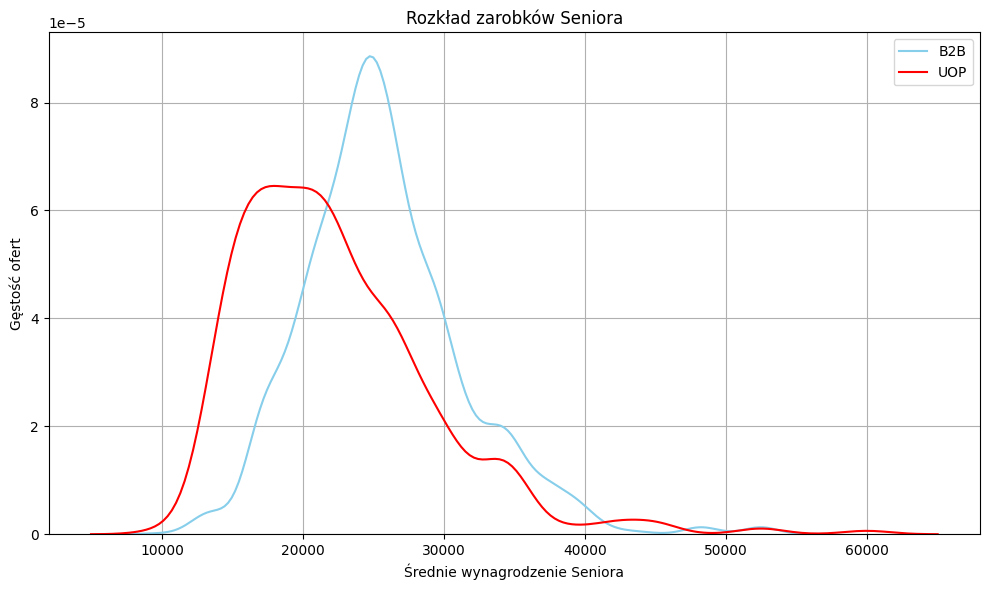

Rozkład wynagrodzeń dla Junior, liczba ofert z b2b: 101
Rozkład wynagrodzeń dla Junior, liczba ofert z uop: 58


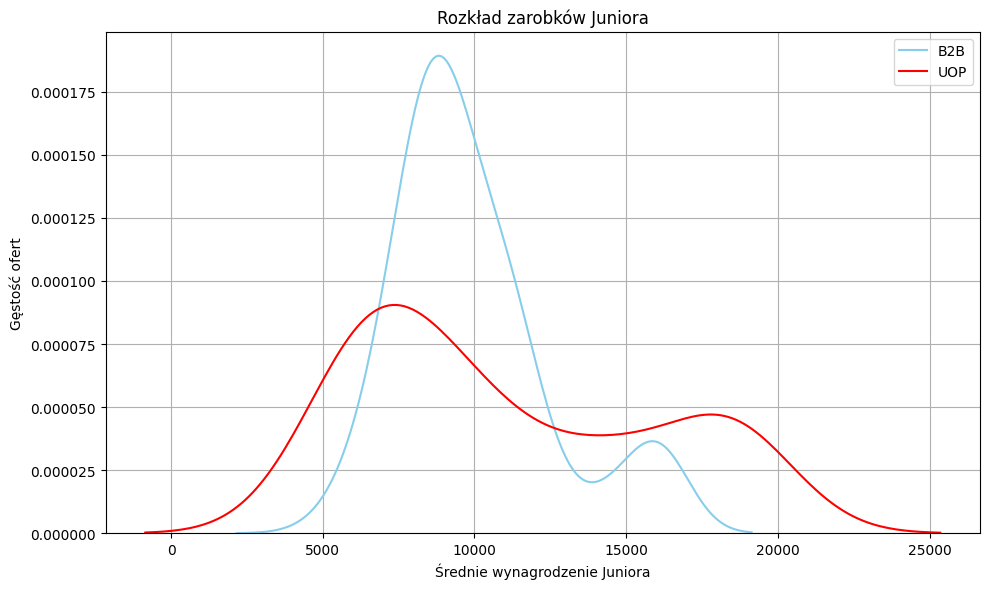

In [460]:
salary_distribution(df, "Mid")
salary_distribution(df, "Senior")
salary_distribution(df, "Junior")

# Rozkład popularności technologii

In [461]:
def popularity(data, start_column, end_column, title, xlabel, ylabel, figsize=(22, 6), color='blue'):
    technologies = data.loc[:, start_column:end_column]

    sum_of_tech = technologies.sum().sort_values(ascending=False)

    plt.figure(figsize=figsize)
    sum_of_tech.plot(kind='bar', color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/rozkłady/{title.lower().replace(" ", "_")}.png")
    plt.show()


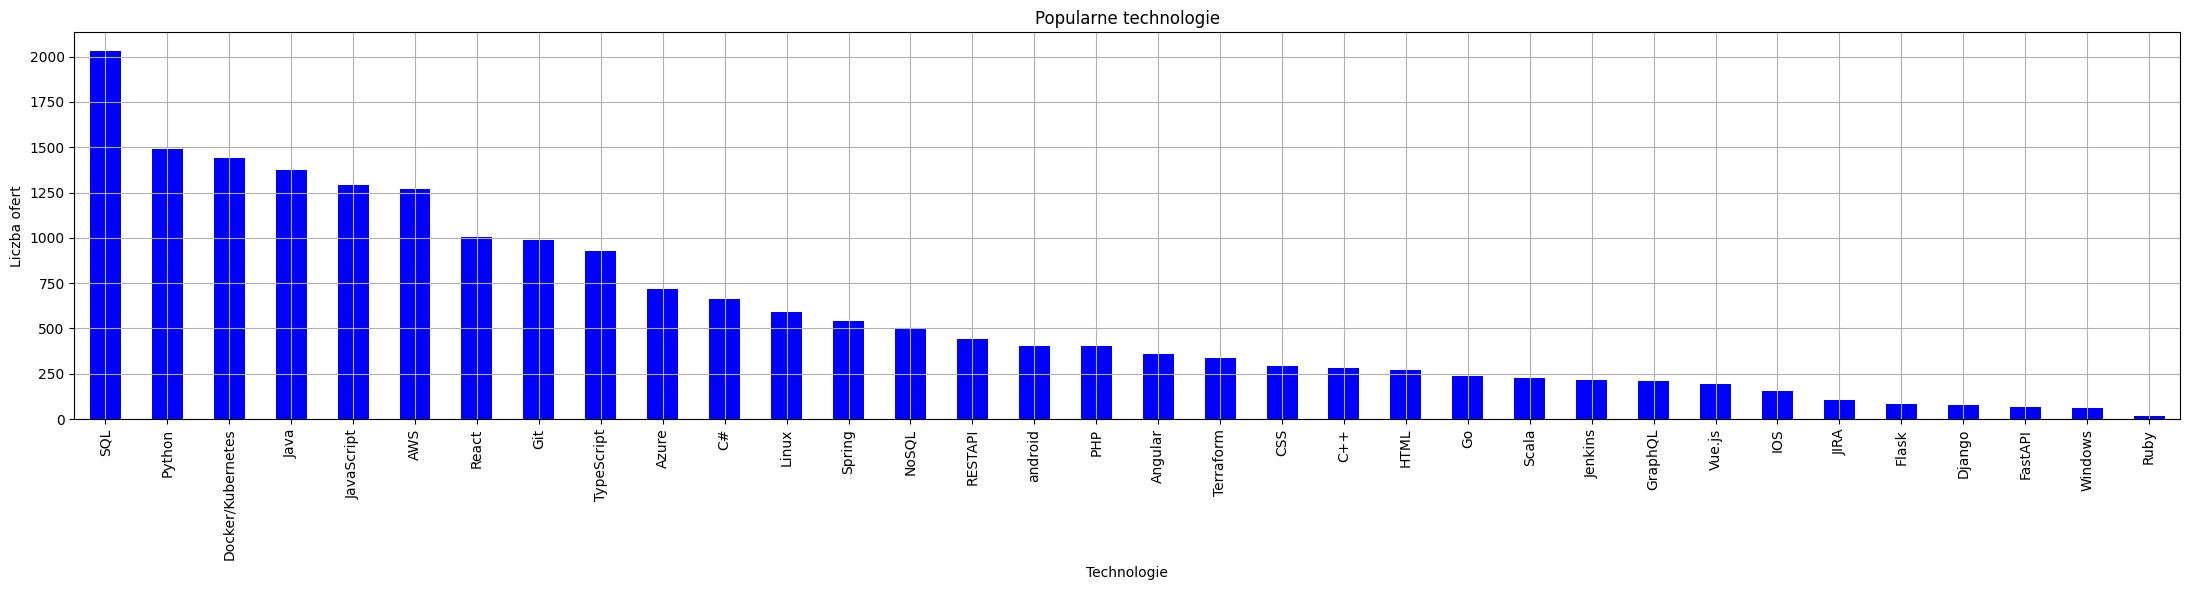

In [462]:
popularity(df, 'AWS', 'android', 'Popularne technologie', 'Technologie', 'Liczba ofert')

# Rozkład lokalizacji

Warszawa     1009
Kraków        836
Wrocław       753
Gdańsk        625
Poznań        599
Katowice      412
Łódź          365
Rzeszów       246
Lublin        229
Bydgoszcz     148
Białystok     129
Toruń          88
Name: count, dtype: int64


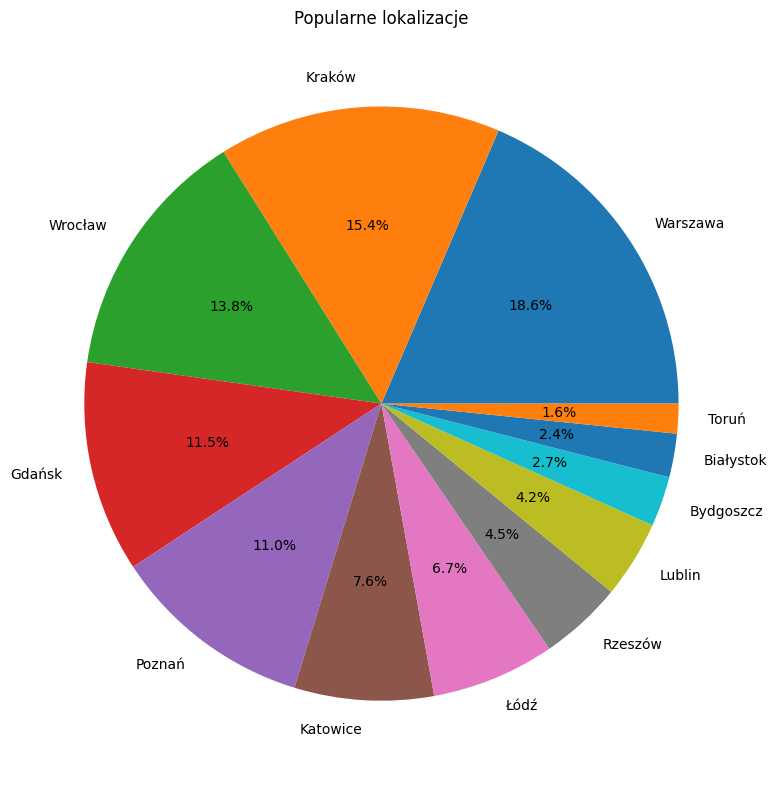

In [463]:
get_histogram(df, 'location_code', 'Popularne lokalizacje', location_encoder, label_x="", label_y="")

Experience: Junior
Warszawa     30
Wrocław      25
Gdańsk       17
Poznań       17
Kraków       17
Katowice     15
Łódź          8
Rzeszów       6
Toruń         5
Gliwice       5
Lublin        4
Białystok     3
Name: count, dtype: int64


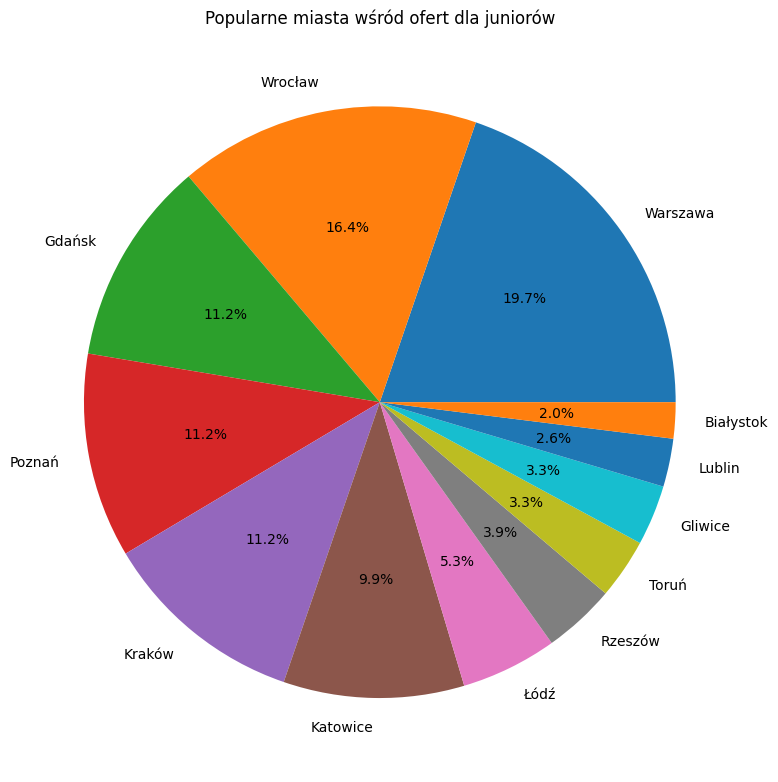

In [464]:
get_histogram(df, 'location_code', 'Popularne miasta wśród ofert dla juniorów', location_encoder, label_x="", label_y="", is_specified=True, exp="Junior")

# Macierz korelacji techonlogii

Czy jakieś techonologie idą ze sobą w parze.


In [465]:
def create_corr_plot(corr, title, size=(20,20)):
    plt.figure(figsize=size)
    sns.heatmap(corr, annot=True,fmt=".2f", linecolor="lightgrey", linewidths=0.5, cmap="flare")
    sns.color_palette("flare", as_cmap=True)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"plots/korelacje/{title.lower().replace(" ", "_")}.png")
    plt.show()

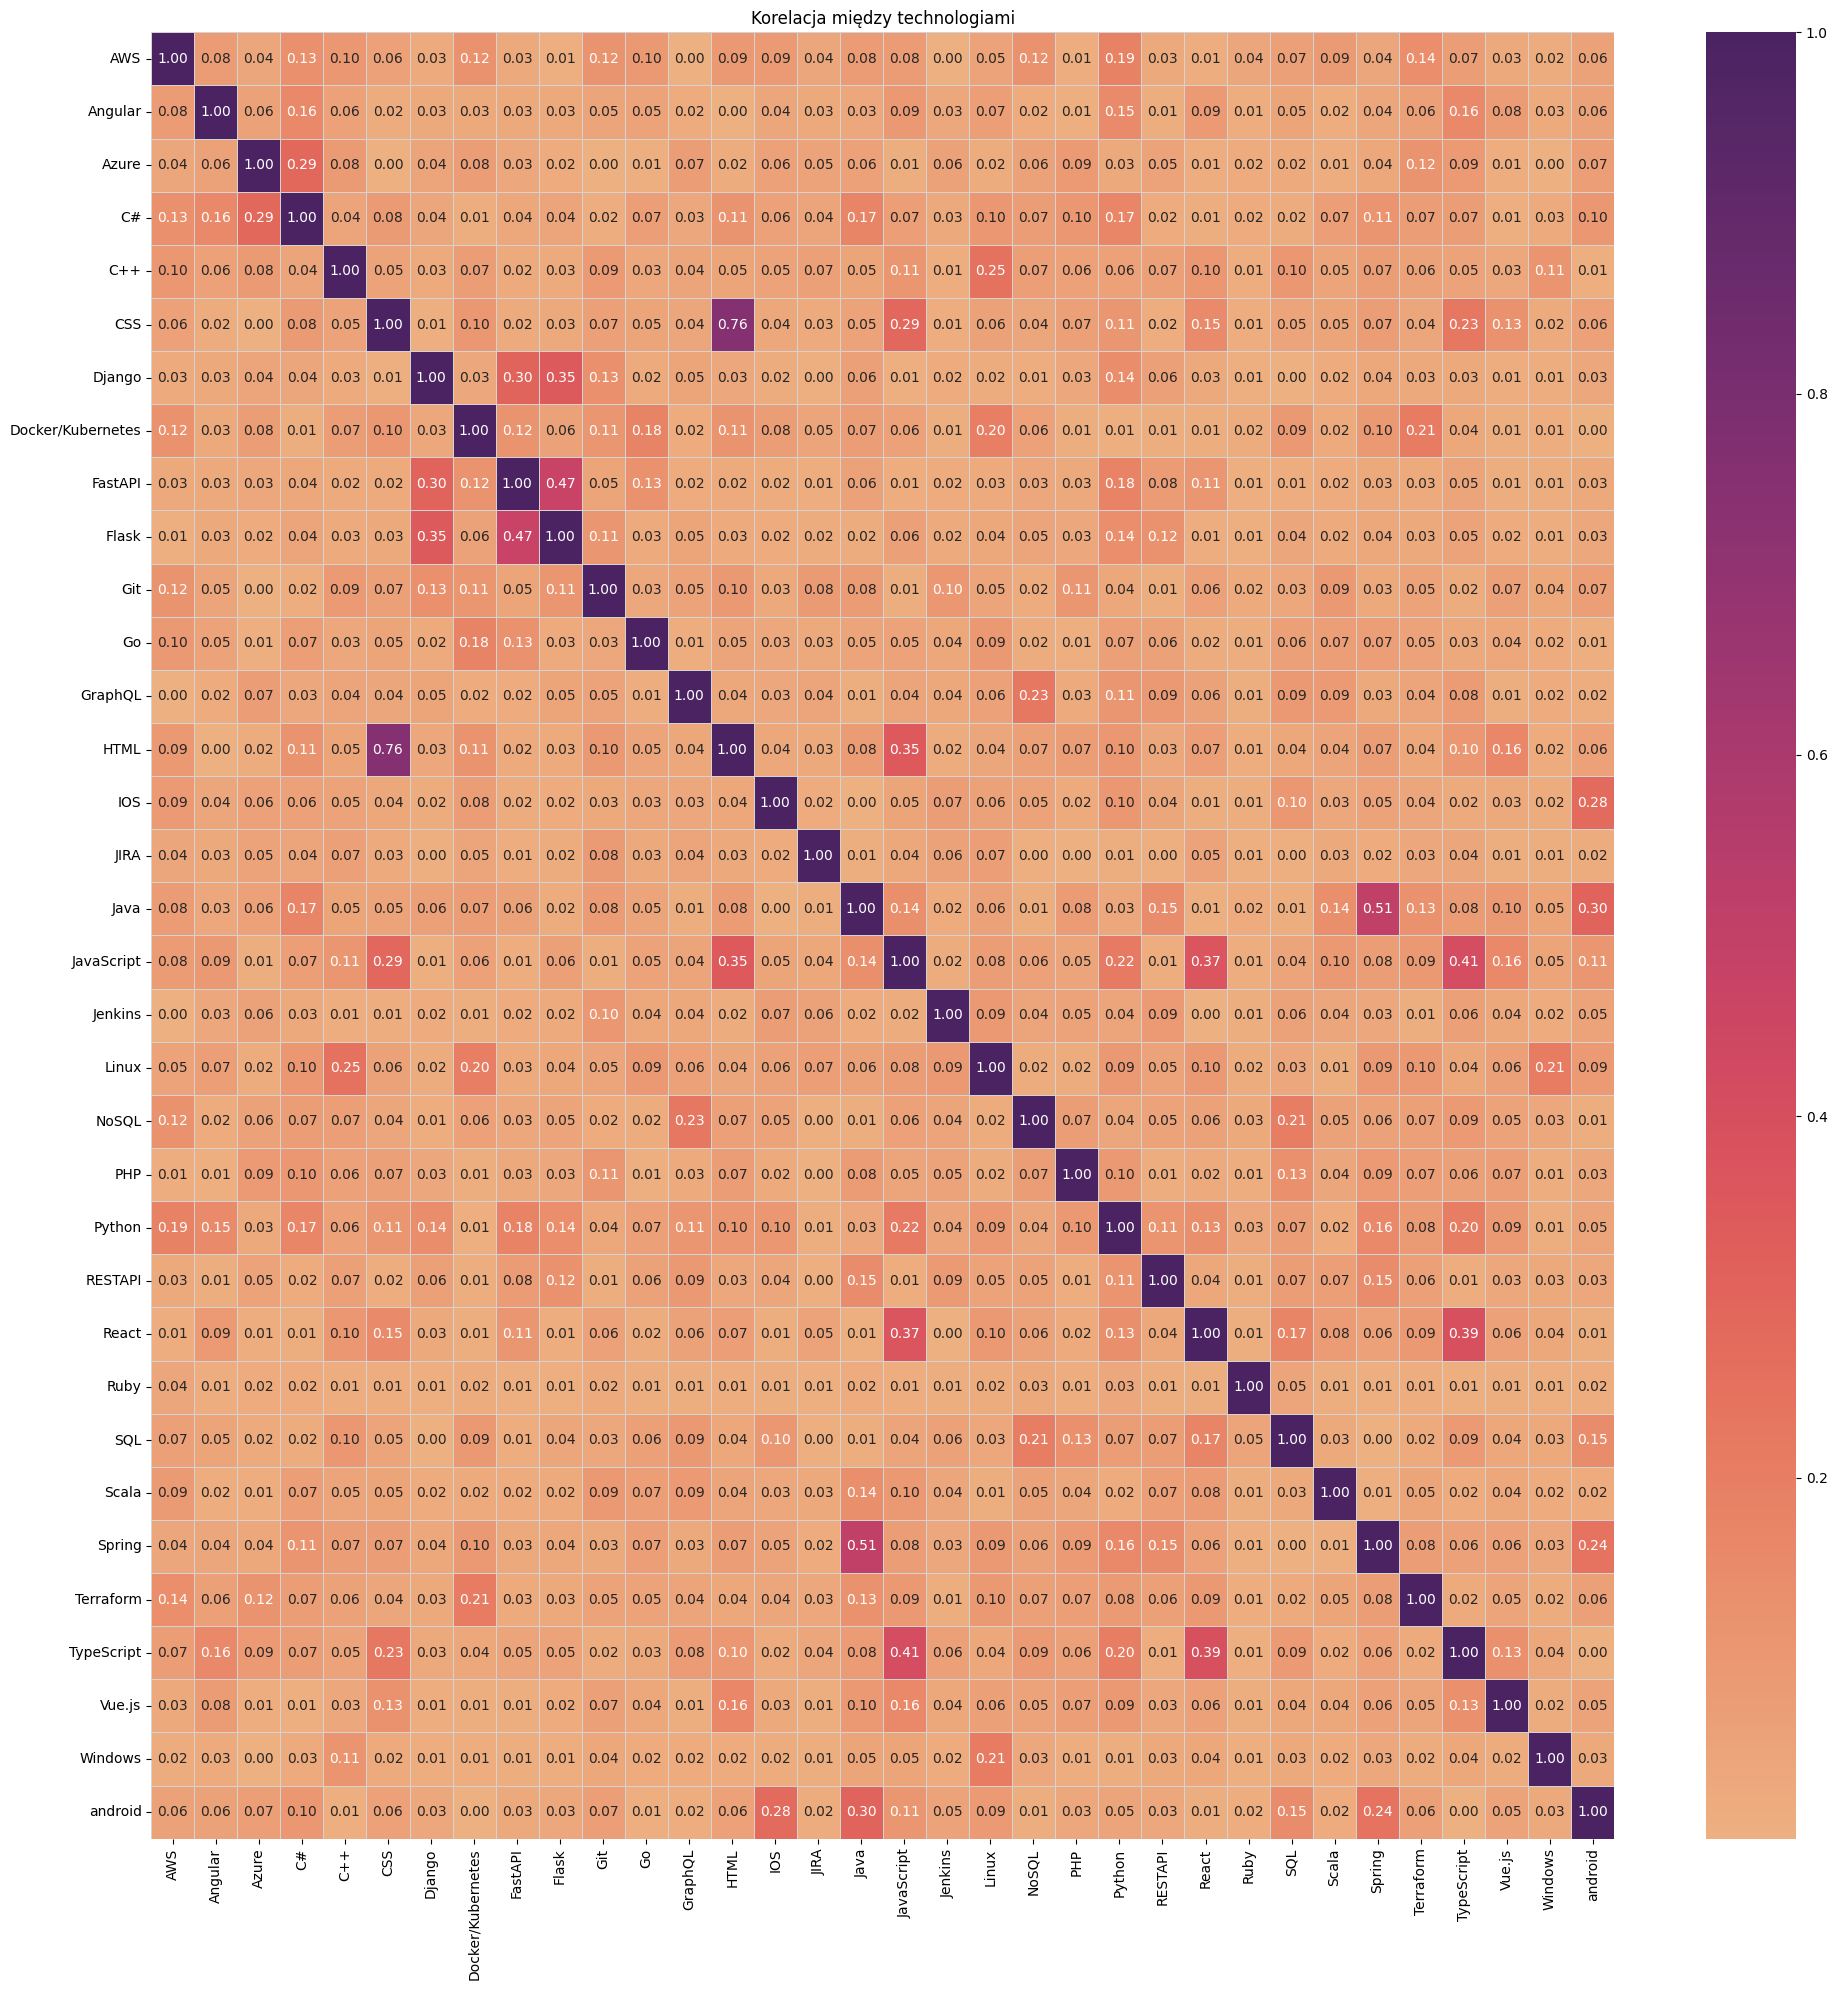

In [466]:
# Obliczenie korelacji między wybranymi kolumnami
technologies = df.loc[:, "AWS": "android"].columns.tolist()
corr = df[technologies].corr()
corr = corr.abs()
create_corr_plot(corr, 'Korelacja między technologiami')


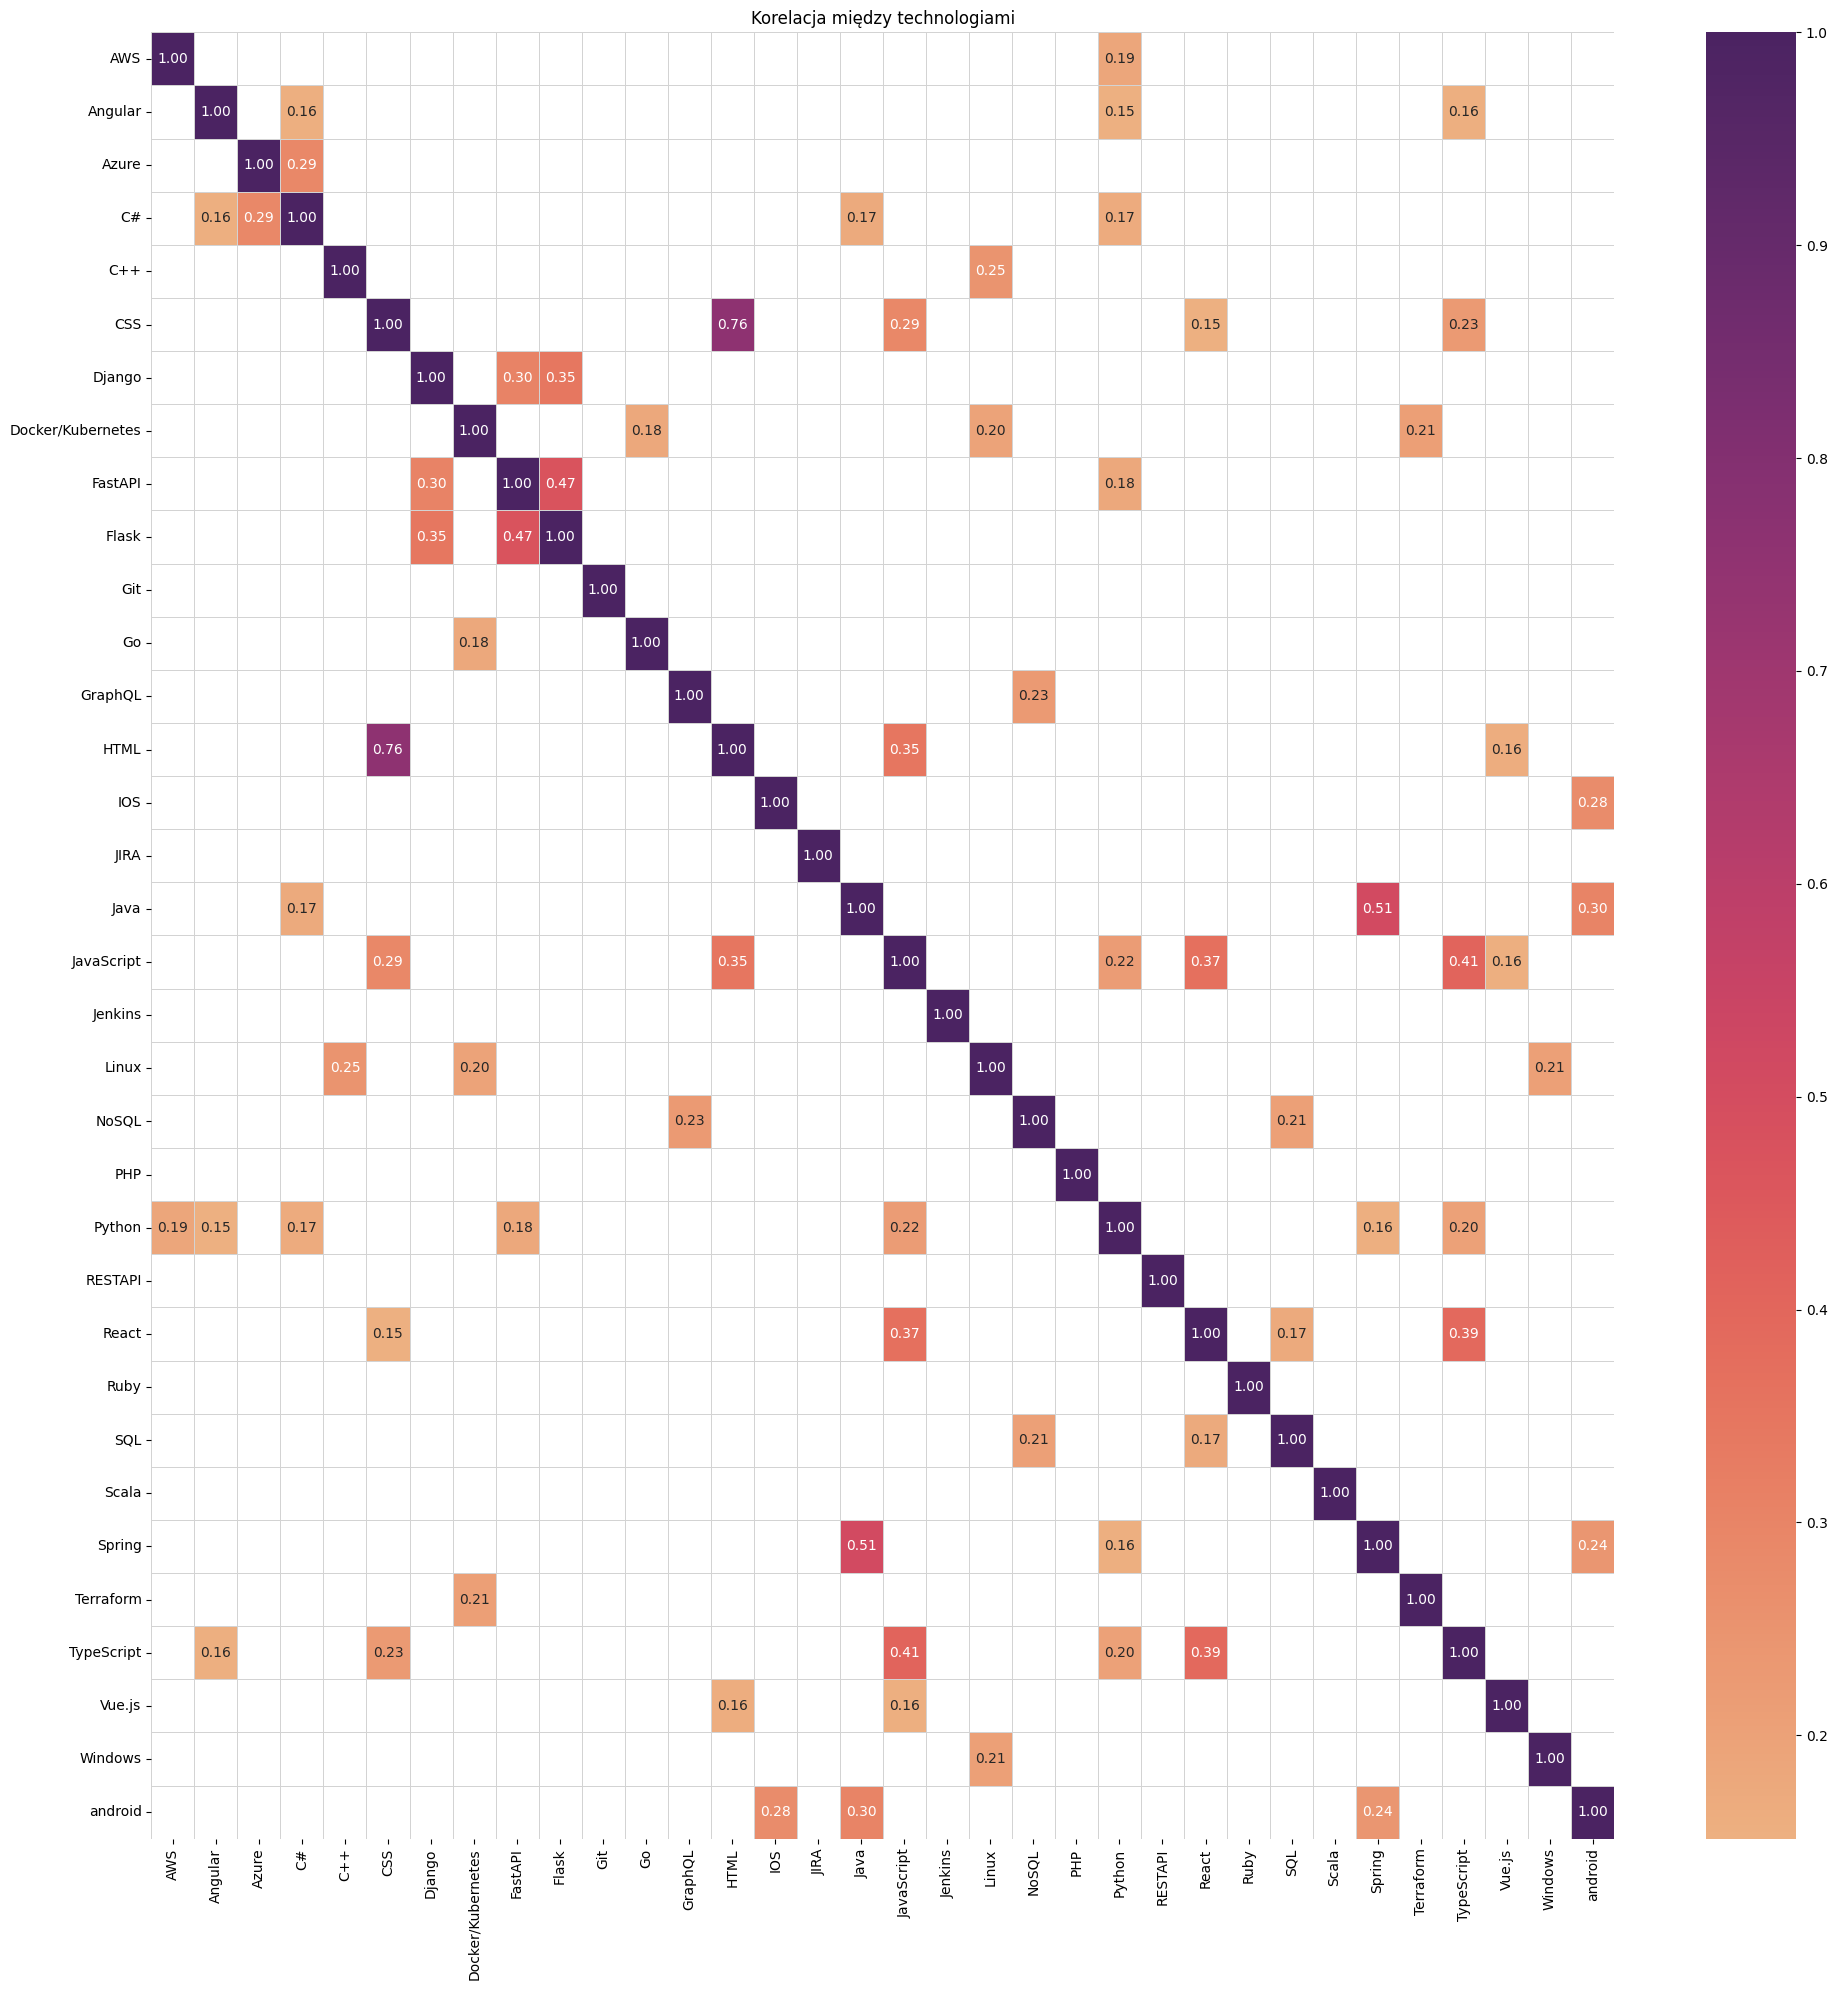

In [467]:
technologies = df.loc[:, "AWS": "android"].columns.tolist()
corr_matrix = df[technologies].corr().abs()

mask = corr_matrix > 0.15

filtered_corr = corr_matrix[mask]

create_corr_plot(filtered_corr, 'Korelacja między technologiami')

# Macierz korelacji wybranych zmiennych

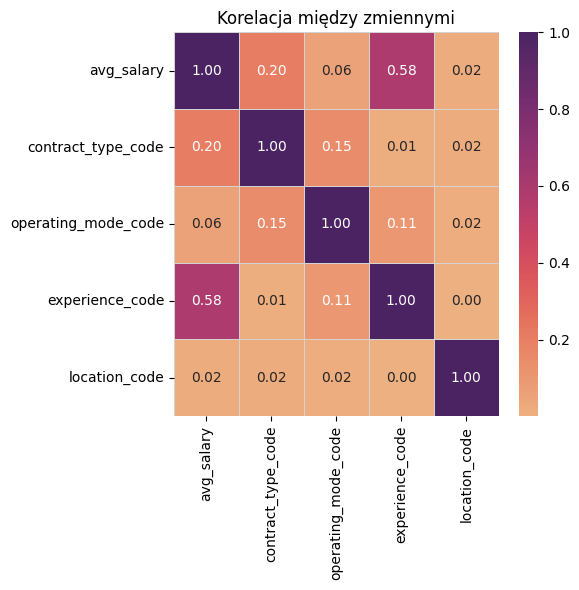

In [468]:
vars = ["avg_salary", "contract_type_code", "operating_mode_code", "experience_code", "location_code"]

corr = data[vars].corr()
corr = corr.abs()

create_corr_plot(corr, 'Korelacja między zmiennymi', size=(6,6))



# Zarobki a technologie

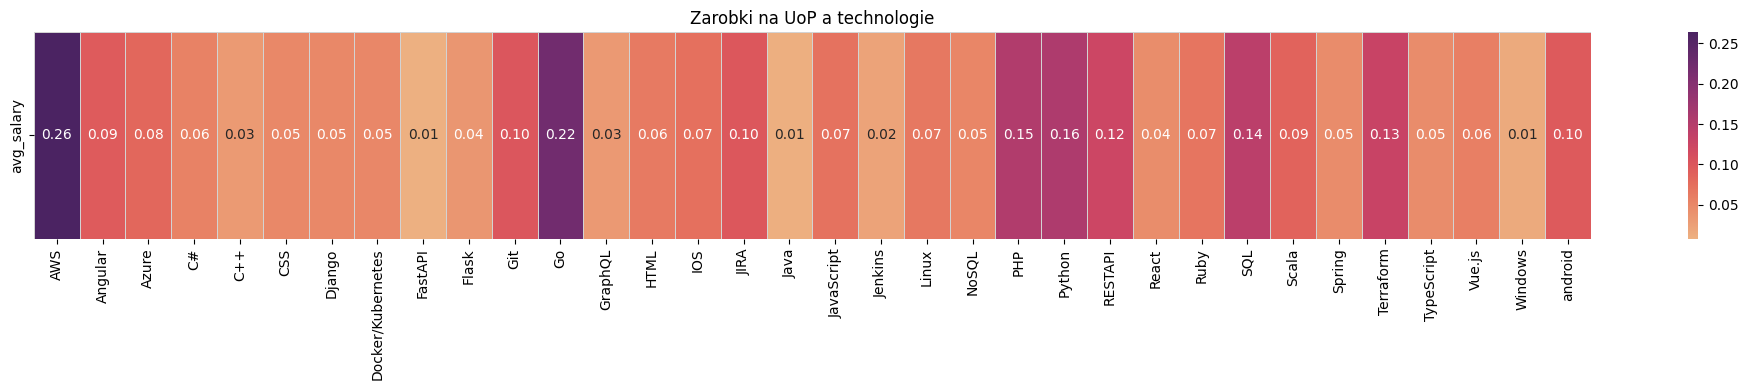

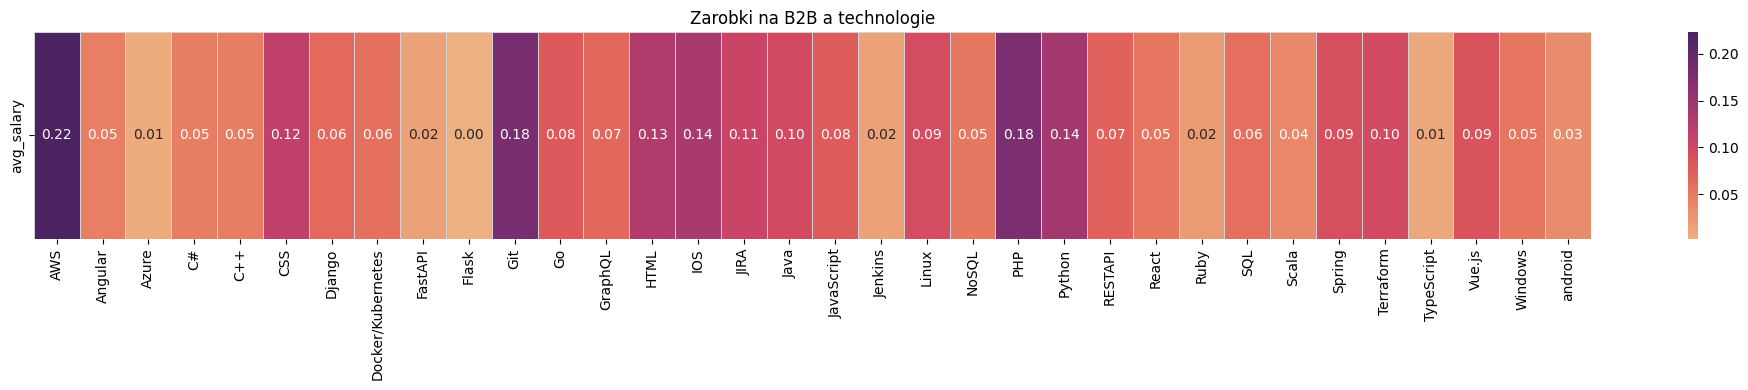

In [469]:
techs = data.loc[:, "AWS": "android"]

b2b, uop = contract_type_encoder.transform(["B2B", "UoP"])

uop_data = data[data['contract_type_code'] == uop]

b2b_data = data[data['contract_type_code'] == b2b]

uop_salaries = ["avg_salary"]
uop_all_vars = uop_salaries + list(techs.columns)
uop_corr = uop_data[uop_all_vars].corr()
uop_corr = uop_corr.abs()  
uop_corr = uop_corr.loc[uop_salaries, techs.columns] 

create_corr_plot(uop_corr, "Zarobki na UoP a technologie", size=(20, 4))

b2b_salaries = ["avg_salary"]
b2b_all_vars = b2b_salaries + list(techs.columns)
b2b_corr = b2b_data[b2b_all_vars].corr()
b2b_corr = b2b_corr.abs()  
b2b_corr = b2b_corr.loc[b2b_salaries, techs.columns] 

create_corr_plot(b2b_corr, "Zarobki na B2B a technologie", size=(20, 4))

# Korelacja technologii a lokalizacji

/tmp/ipykernel_4946/584414074.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


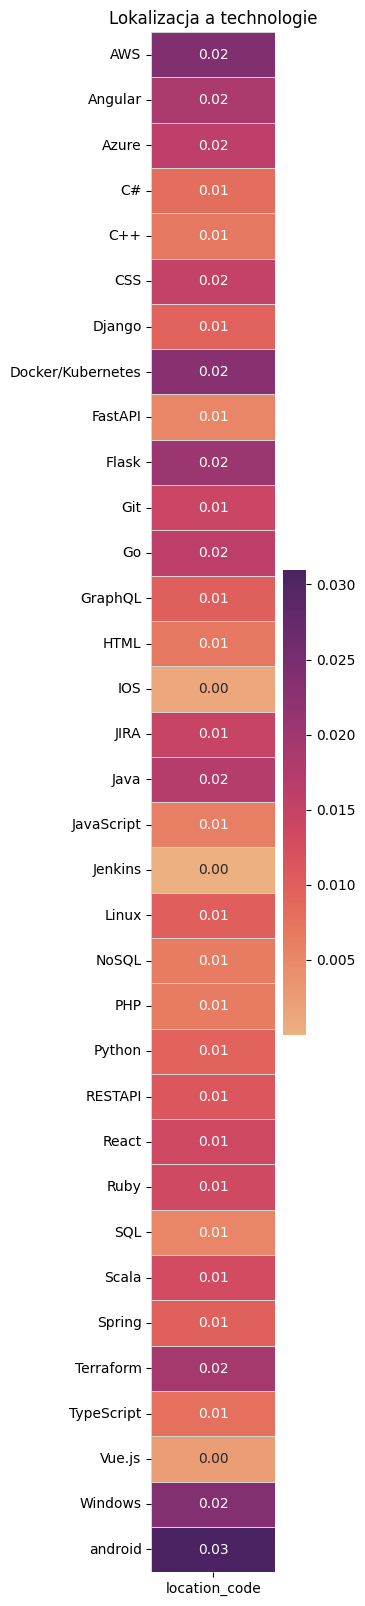

In [470]:
corr = data[["location_code"] + list(techs.columns)].corr()
corr = corr.abs()
corr = corr.loc[techs.columns, ["location_code"]]
create_corr_plot(corr, "Lokalizacja a technologie", size=(2, 20))

# Przygotowanie modeli

Wybrałem Regresje Liniową, Las losowy i drzewko decyzji.

**Dlaczego?**

- Regresja liniowa: jest to najprostszy model regresji, który zakłada liniową zależność między zmiennymi i pojawiła się na zajęciach.

- Random Forest: podobno skuteczny model (z polecenia znajomego), który jest złożeniem wielu drzew decyzyjnych.

- Drzewo decyzyjne: jest to najprostszy model, który zakłada, że dane są liniowe.


Nie wykluczam, ze będę testował inne modele, ale na razie zacznę od tych trzech.

Inne modele, które mogę przetestować:

- Lasso
- Ridge

In [471]:
models_to_tune = {
    'Linear_Regression':{
        'model':LinearRegression(),
        'params':{}
    },
    'Decision_Tree':{
        'model':DecisionTreeRegressor(),
        'params':{
            'max_depth':[2,4,6,8,10],
            'random_state':[0,42],
            'min_samples_split':[2,5,10,20]
        }
    },
    'Random_Forest':{
        'model':RandomForestRegressor(n_estimators=20),
        'params':{
            'n_estimators':[10,30,20,50,80]
        }
    },
    'Ridge':{
        'model':Ridge(alpha=.1),
        'params':{
            'alpha':[0.1,0.5,1,2,5,10]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 0.5, 1, 2, 5, 10]
        }
    }
}

In [472]:
# Hyper parameter tuning through grid search cv
from sklearn.model_selection import GridSearchCV


def tune_models(x_train, y_train):
    scores = []

    for name, value in models_to_tune.items():
        clf = GridSearchCV(value['model'], value['params'], cv=5, scoring='neg_mean_squared_error')
        clf.fit(x_train, y_train)

        scores.append({
            'Model': name,
            'Params': clf.best_params_,
            'MSE(-ve)': clf.best_score_
        })
    pd.DataFrame(scores).to_csv("models_tuning.csv", index=False)

In [473]:
parameters_for_models = pd.read_csv('models_tuning.csv')

model_params = {}

for index, row in parameters_for_models.iterrows():
    model_name = row['Model']
    params = eval(row['Params'])
    model_params[model_name] = params

n_estimators = model_params['Random_Forest']['n_estimators']

max_depth = model_params['Decision_Tree']['max_depth']
min_samples_split = model_params['Decision_Tree']['min_samples_split']
random_state = model_params['Decision_Tree']['random_state']

alpha_ridge = model_params['Ridge']['alpha']

alpha_lasso = model_params['Lasso']['alpha']

models = [
    LinearRegression(), DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, random_state=random_state),
    RandomForestRegressor(n_estimators=n_estimators), Ridge(alpha=alpha_ridge),
    Lasso(alpha=alpha_lasso)
]

In [474]:
class Plotter:
    
    def __init__(self, data, y_pred, y_train, y_test, test_size, model_title) -> None:
        self.data = data
        self.y_pred = y_pred
        self.y_train = y_train
        self.y_test = y_test
        self.test_size = test_size
        self.model_title = model_title
        self.dest = f"plots/wyniki/{1-self.test_size}&{self.test_size}/{self.model_title}/"
        
        import os
        if not os.path.exists(self.dest):
            os.makedirs(self.dest)
            
    
    def get_plots(self):
        self.plot_salary_distribution()
        self.plot_with_errors()
        self.scatter_plot()
        # ...
    
    def plot_salary_distribution(self):
        # if self.contract == "b2b":
        #     real_salaries = self.data[self.data["avg_b2b"] > 0]["avg_b2b"]
        # else:
        #     real_salaries = self.data[self.data["avg_uop"] > 0]["avg_uop"]

        plt.figure(figsize=(14, 6))

        sns.kdeplot(self.data['avg_salary'], color='blue', label=f"Rzeczywiste zarobki")

        sns.kdeplot(self.y_pred, color='orange', label=f"Przewidziane zarobki")

        plt.title(f"Rozkład dla {self.model_title}")
        plt.xlabel(f"Zarobki (PLN)")
        plt.ylabel("Gęstość ofert")
        plt.legend()

        plt.tight_layout()
        plt.savefig(self.dest + "salary_dist.png")
        plt.show()

    
    def plot_with_errors(self):
        errors = self.y_test - self.y_pred   
        plt.hist(errors, bins='auto')
        plt.xlabel('Przedziały błędów predykcji')
        plt.ylabel('Ilość')
        plt.title(f'Histogram błędów predykcji dla {self.model_title}')
        plt.savefig(self.dest + "errors.png")
        plt.show()
    
    def scatter_plot(self):
        plt.scatter(self.y_test, self.y_pred)
        plt.xlabel('Prawdziwe dane')
        plt.ylabel('Przewidziane dane')
        plt.plot([self.y_test.min(), self.y_test.max()], [self.y_test.min(), self.y_test.max()], color='red') 
        plt.title(f'Prawdziwe vs Przewidziane zarobki dla {self.model_title}')
        plt.savefig(self.dest + "scatter.png")
        plt.show()

# Wybieramy najlepszy model

Tutaj to zalezy od danych wejściowych, czasami zwraca Regresje Liniową, a czasami Random Forest.

In [475]:
def get_best_model(models, x_train, x_test, y_train, y_test, short=True, test_size=0.2):    
    metrics_list = []
    
    def eval_model(model, x_train, x_test, y_train, y_test):
        model.fit(x_train, y_train)
        # score = model.score(x_test, y_test)
        y_pred = model.predict(x_test)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        metrics = {
            "Model": model.__class__.__name__,
            "Mean Absolute Error": mean_absolute_error(y_test, y_pred).round(2),
            "Root Mean Squared Error": score.round(2),
            "R^2 Score": r2_score(y_test, y_pred)
        }
        
        plotter = Plotter(data=data, y_pred=y_pred, y_train=y_train, y_test=y_test, test_size=test_size, model_title=model.__class__.__name__)
        plotter.get_plots()
        
        return score, metrics

    best_score = float('inf')
    best_model = None
    
    tune_models(x_train, y_train)

    for model in models:
        score, metrics = eval_model(model, x_train, x_test, y_train, y_test)
        if score < best_score:
            best_score = score
            best_model = model
        metrics_list.append(metrics)
    
    metrics_df = pd.DataFrame(metrics_list)
    dest = f"plots/wyniki/{1-test_size}&{test_size}/metrics.csv"
    metrics_df.to_csv(dest, index=False)
                
    return best_model

In [476]:
def create_model_other_method(data, test_size=0.2):
    tmp_data = data.copy()
 
    features = tmp_data.drop(columns=["avg_salary"], axis=1)
    lables = tmp_data[['avg_salary']]
    
    salary = lables["avg_salary"]
    
    x_train, x_test, y_train, y_test = train_test_split(features, salary, test_size=test_size, random_state=42)
    
    best_model = get_best_model(models, x_train, x_test, y_train, y_test, short=False, test_size=test_size)
    
    return best_model

In [477]:
def preprocess_input(**params):
  location_code = location_encoder.transform([params["location"]])[0]
  exp_code = exp_encoder.transform([params["exp"]])[0]
  operating_mode_code = mode_encoder.transform([params["operating_mode"]])[0]
  tech_stack = mlb.transform([params["tech_stack"]])[0]
  contract_type_code = contract_type_encoder.transform([params["contract_type"]])[0]
  
  res = np.concatenate([[contract_type_code, location_code, exp_code, operating_mode_code], tech_stack]).reshape(1, -1)
  print(res)
  return pd.DataFrame(res)

In [478]:
def plot_impotance(model, data):
    importances = model.feature_importances_
    features = data.columns
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(20, 12))
    plt.title("Jak bardzo cechy wypływały na zarobek")
    plt.bar(range(data.shape[1]), importances[indices], align="center")
    plt.xticks(range(data.shape[1]), [features[i] for i in indices], rotation=90)
    plt.xlim([-1, data.shape[1]])
    plt.tight_layout()
    plt.savefig("../analysis/plots/wyniki/importance_of_vars.png")
    plt.show()

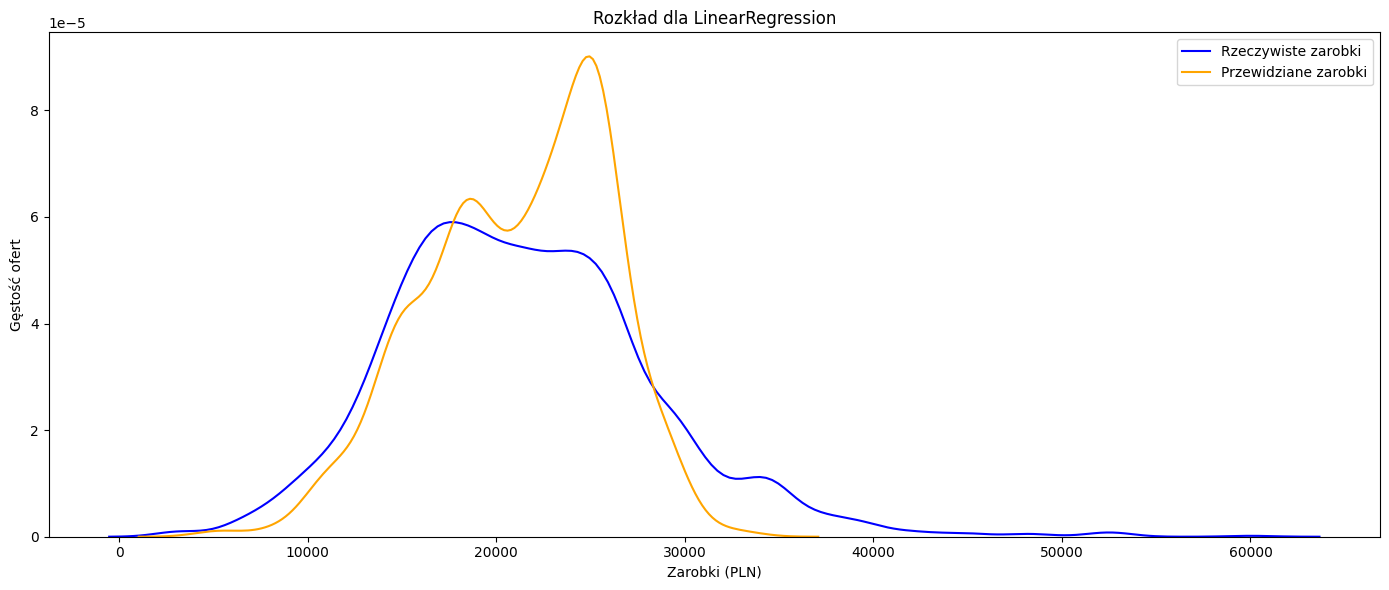

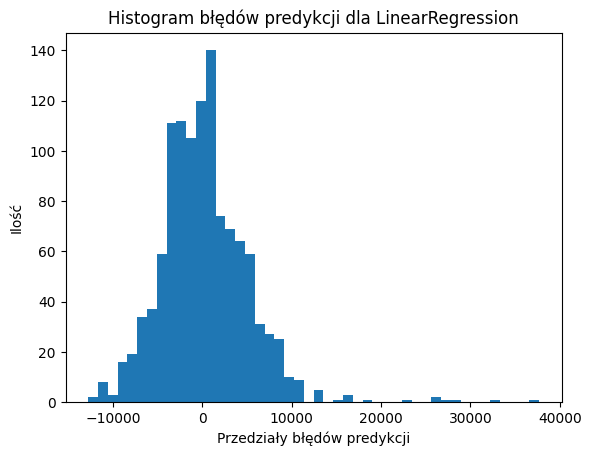

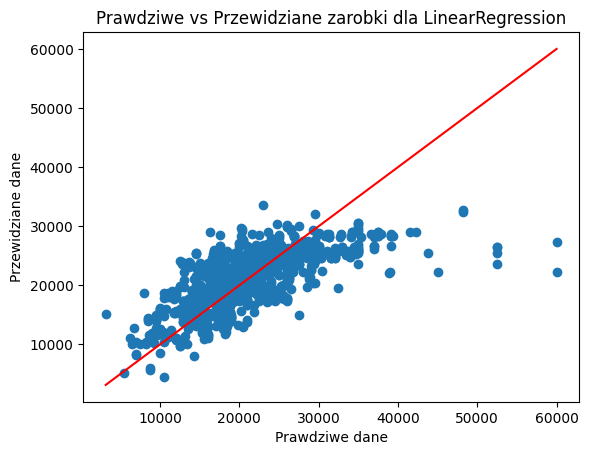

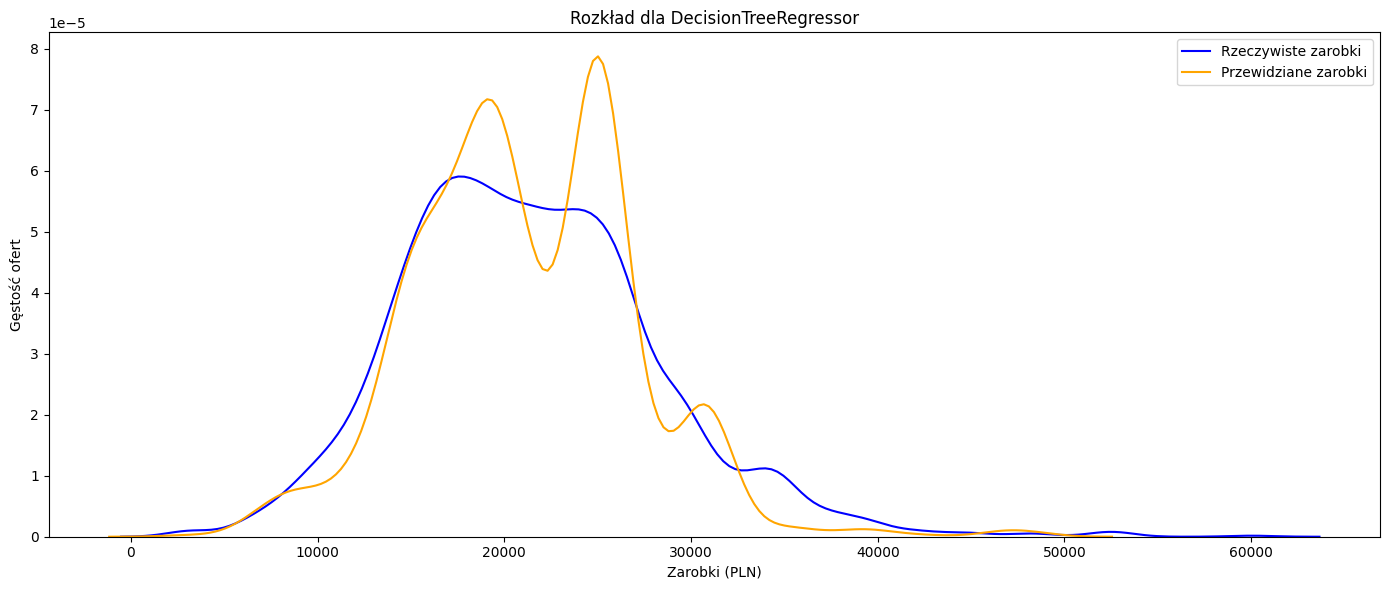

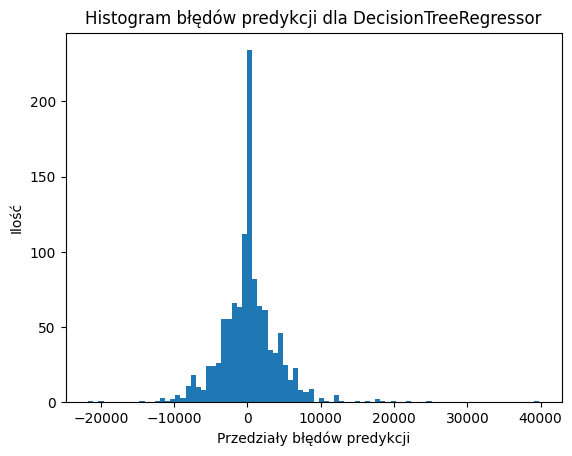

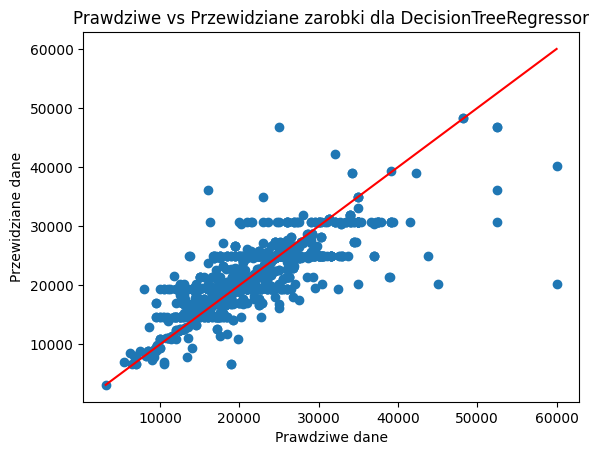

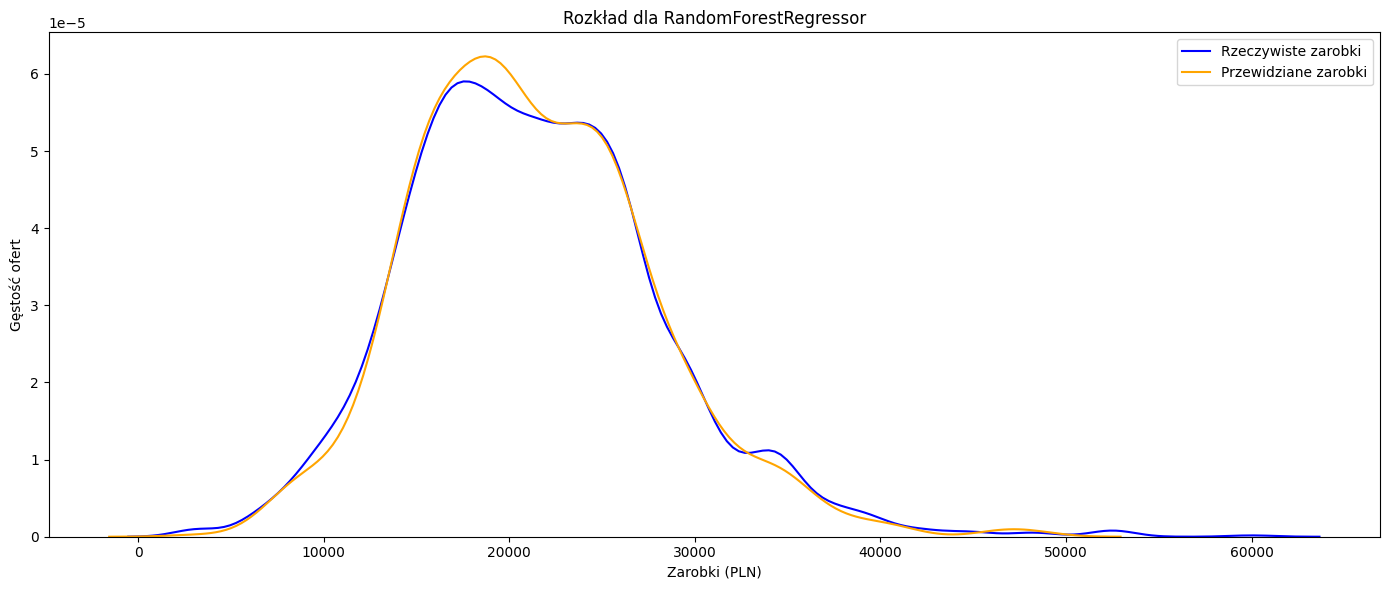

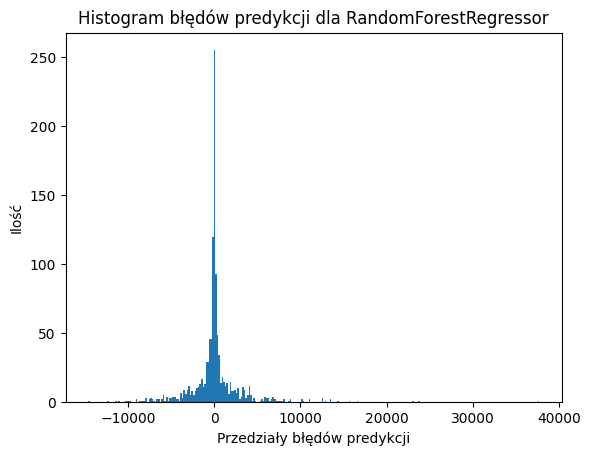

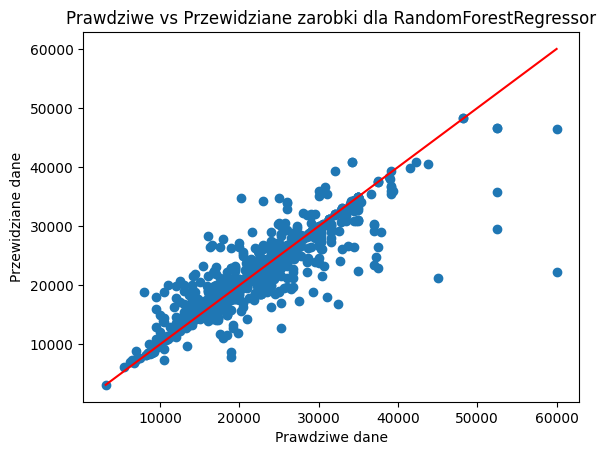

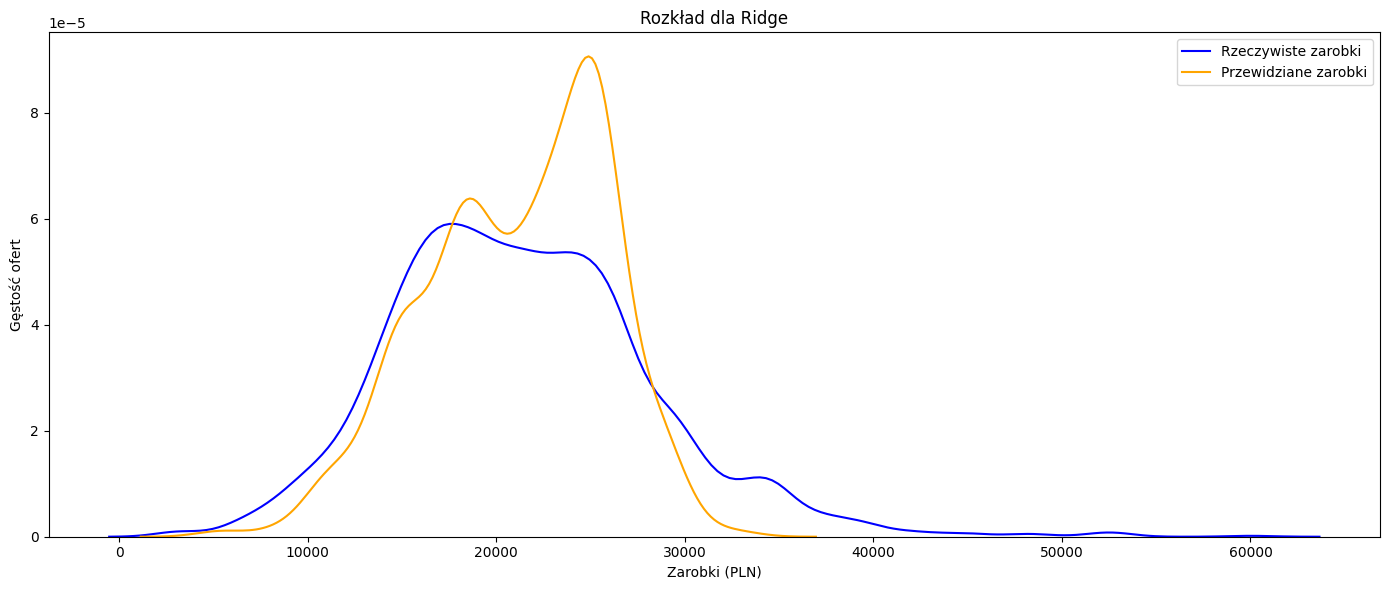

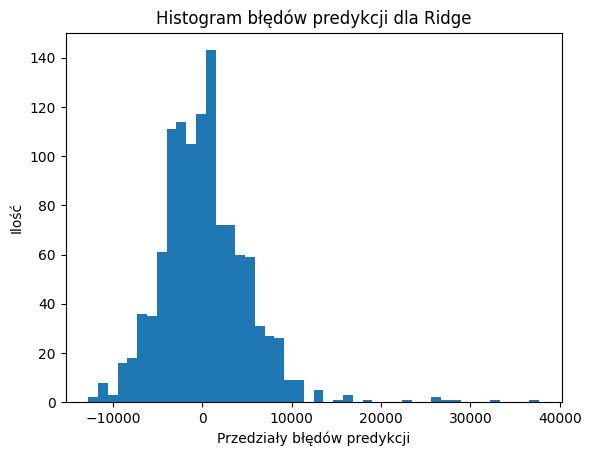

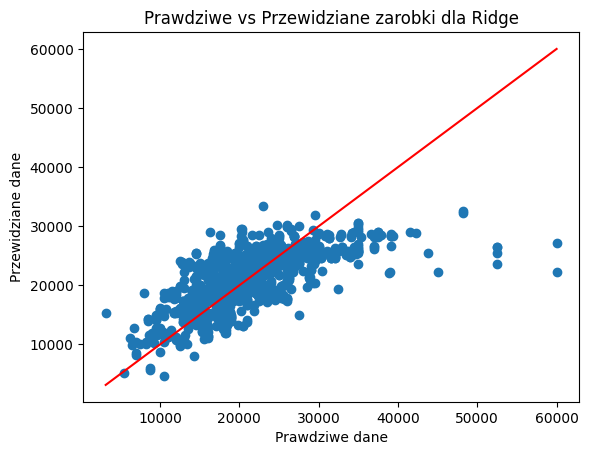

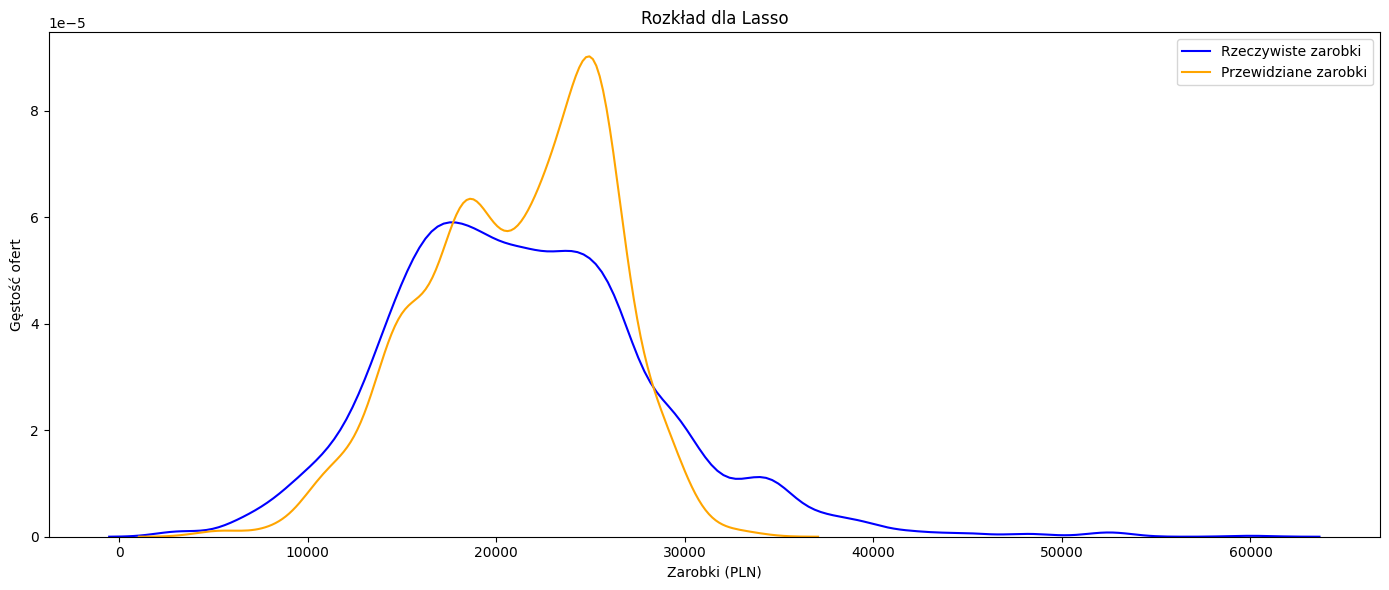

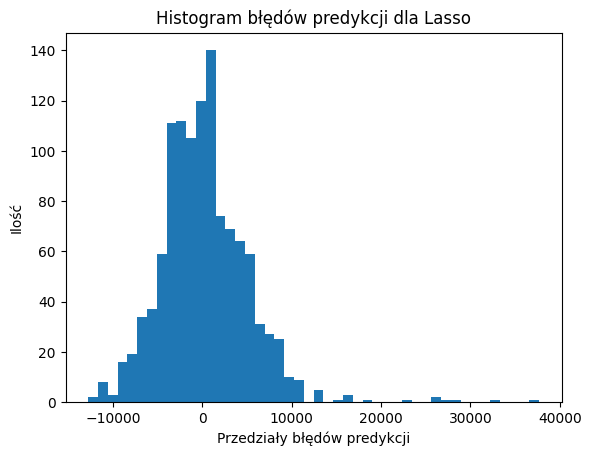

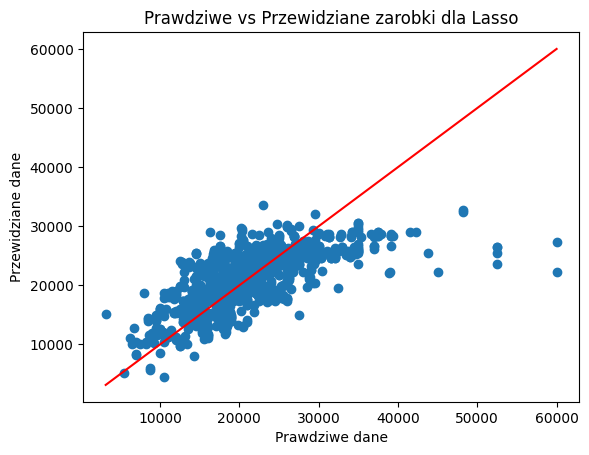

In [479]:
model = create_model_other_method(data, test_size=0.2)

In [480]:
test_uop = {
    "location": "Wrocław",
    "exp": "Junior",
    "operating_mode": "Hybrid",
    "contract_type": "UoP",
    "tech_stack": ["Docker/Kubernetes", "Python", "Linux", "React", "TypeScript", "JavaScript"]
}

test_b2b = {
    "location": "Wrocław",
    "exp": "Junior",
    "operating_mode": "Hybrid",
    "contract_type": "B2B",
    "tech_stack": ["Docker/Kubernetes", "Python", "Linux", "React", "TypeScript", "JavaScript"]
}

In [481]:
input_data_uop = preprocess_input(**test_uop)
input_data_b2b = preprocess_input(**test_b2b)

[[ 1 54  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  1
   0  0  1  0  1  0  0  0  0  0  1  0  0  0]]
[[ 0 54  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  1
   0  0  1  0  1  0  0  0  0  0  1  0  0  0]]


In [482]:
inputs = [input_data_uop, input_data_b2b] 

In [486]:
for input in inputs:
    input.columns = model.feature_names_in_
    salary_pred = model.predict(input)
    
    # get vars
    location = location_encoder.inverse_transform([input["location_code"]])[0]
    exp = exp_encoder.inverse_transform([input["experience_code"]])[0]
    operating_mode = mode_encoder.inverse_transform([input["operating_mode_code"]])[0]
    contract_type = contract_type_encoder.inverse_transform([input["contract_type_code"]])[0]
    


/home/lukasz/studia/RaportIT/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lukasz/studia/RaportIT/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lukasz/studia/RaportIT/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lukasz/studia/RaportIT/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A colu

In [484]:
import pickle

with open('../models/model.pkl', 'wb') as file:
    pickle.dump(model, file)

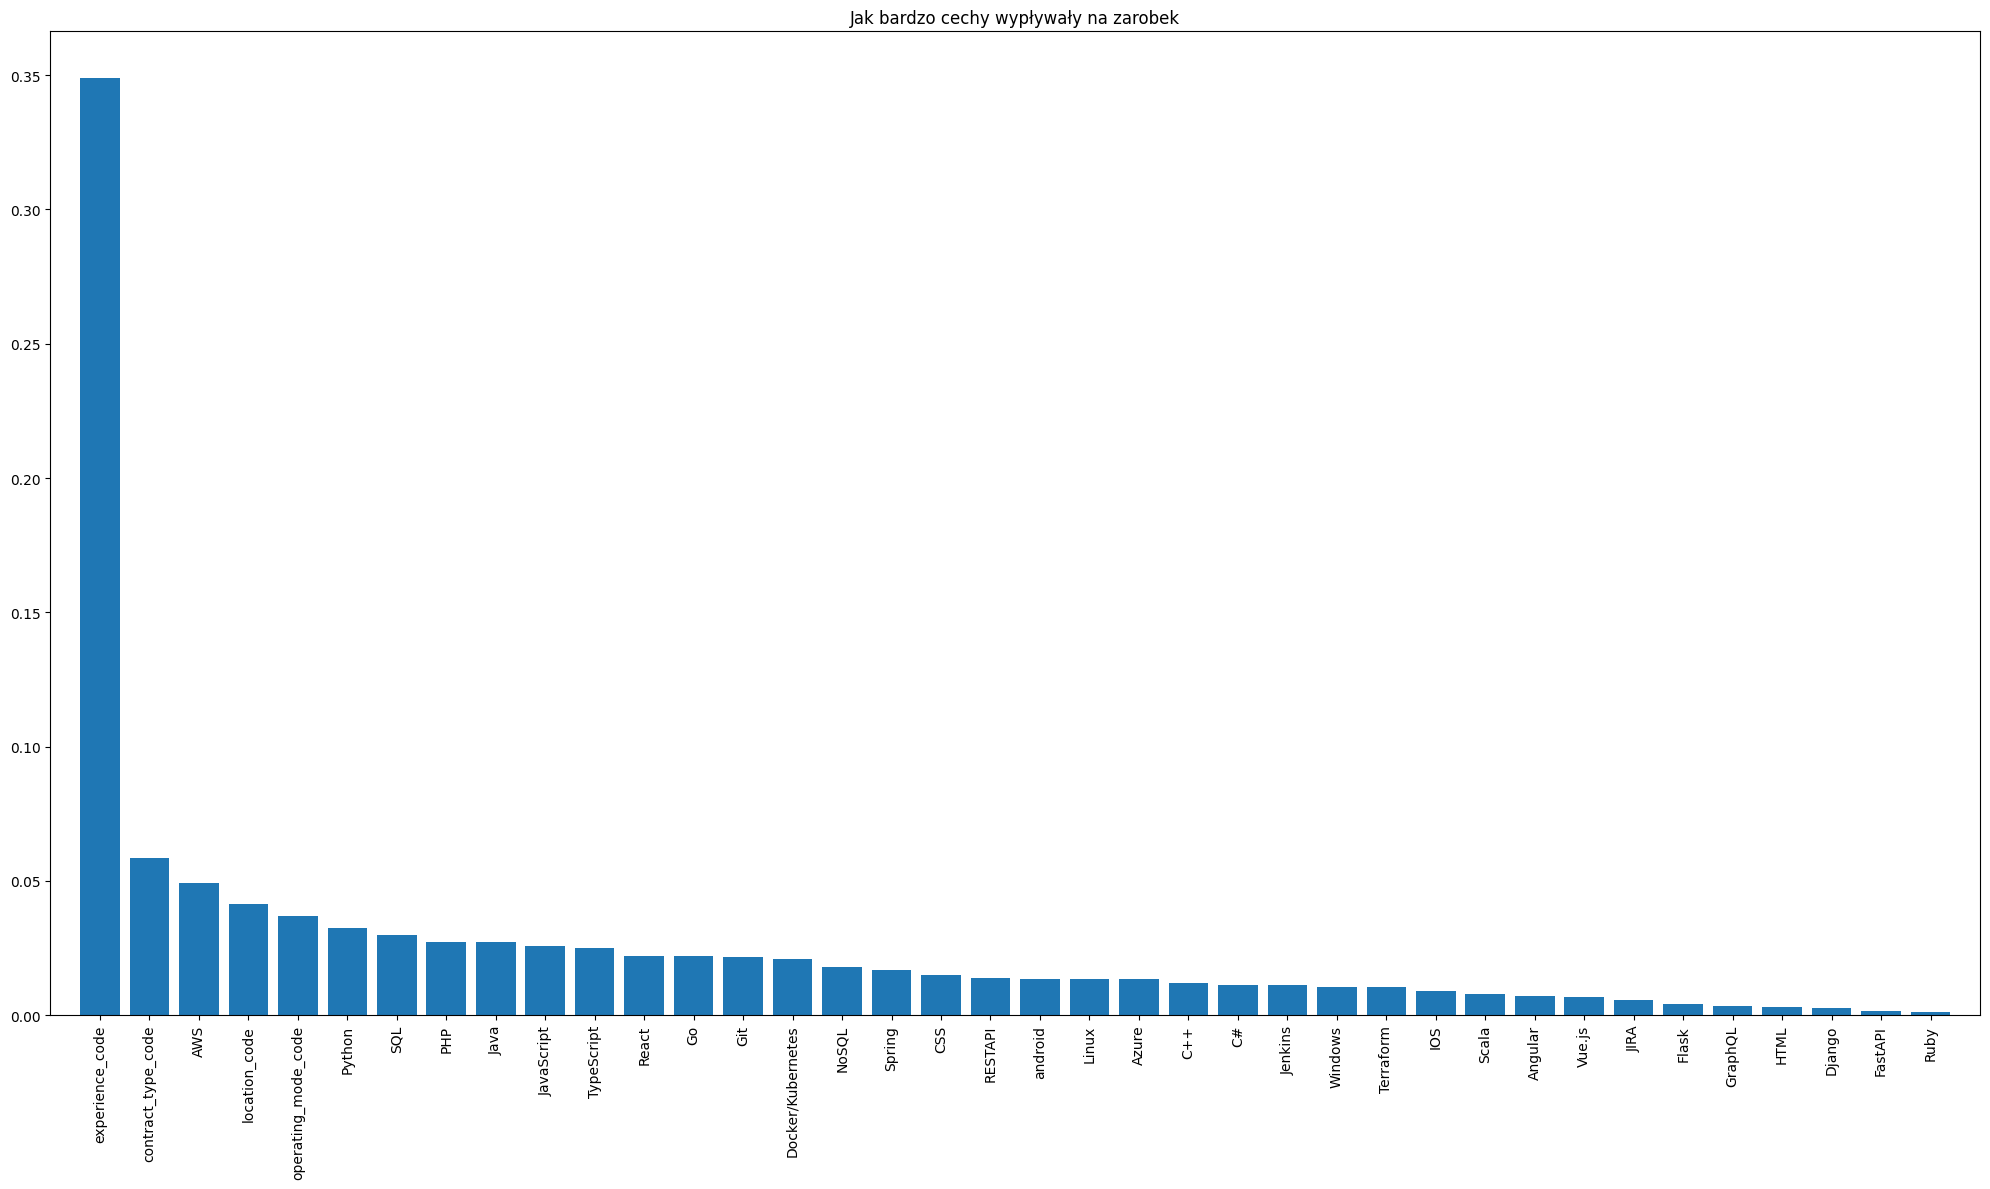

In [485]:
plot_impotance(model, data.drop(columns=['avg_salary'], axis=1))